**Name: Mubanga Nsofu** <br>
**Course: BAN6440, Module 2**<br>
**Email: mnsofu@learner.nexford.org** <br>
**Leaner Id: 149050** <br>
**Institution: Nexford University**<br>
**Lecturer: Professor Bucciarelli** <br>
**Date: 16th November, 2024** <br>
**Task: Optuna-Tuned XGBoost Model for Inventory Management**


In [5]:
# ----------------------------------------------
# Step 0: Install & Load Python Libraries
# ----------------------------------------------

# Install necessary libraries if not already installed
# Uncomment and run the below commands in Jupyter Notebook or your Python environment as needed:
# !pip install pandas numpy optuna scikit-learn matplotlib xgboost joblib

# Import libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation
from xgboost import XGBRegressor  # For the XGBoost regression model
import optuna  # For hyperparameter optimization
import matplotlib.pyplot as plt  # For visualization
import joblib  # For saving the trained model


In [6]:
# ----------------------------------------------
# Step 1: Create Synthetic Data as per the Assignment Question 
# ----------------------------------------------

# Set random seed for reproducibility
np.random.seed(42)

# Number of records
n_records = 300

# Generate 300 synthetic data records
data = {
    "Product_ID": [f"P{str(i).zfill(4)}" for i in range(1, n_records + 1)],
    "Product_Category": np.random.choice(["Personal Care", "Household", "Food"], n_records),
    "Monthly_Sales_Volume": np.random.randint(500, 2000, n_records),
    "Inventory_Levels": np.random.randint(200, 1000, n_records),
    "Reorder_Point": np.random.randint(100, 500, n_records),
    "Lead_Time": np.random.randint(1, 15, n_records),
    "Demand_Variance": np.random.uniform(0.1, 1.0, n_records),
    "Price_Per_Unit": np.random.uniform(5, 50, n_records),
    "Supplier_Reliability_Score": np.random.randint(1, 11, n_records),  # Scores from 1 to 10
}

# Calculate the target variable: Days_to_Stock_out
data["Days_to_Stock_out"] = (
    data["Inventory_Levels"] / (data["Monthly_Sales_Volume"] * data["Demand_Variance"])
).clip(1, 30) + np.random.normal(0, 0.5, n_records) 

# Ensure there are no negative or invalid values
data["Days_to_Stock_out"] = np.maximum(data["Days_to_Stock_out"], 1)  # Minimum of 1 day

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# Display a preview of the synthetic dataset
print("Preview of the Synthetic Dataset:")
print(df.head())

# Save the dataset to a CSV file for submission in the Assignment
df.to_csv("synthetic_inventory_data.csv", index=False)
print("\nSynthetic dataset saved as 'synthetic_inventory_data.csv'.")


Preview of the Synthetic Dataset:
  Product_ID Product_Category  Monthly_Sales_Volume  ...  Price_Per_Unit  Supplier_Reliability_Score  Days_to_Stock_out
0      P0001             Food                  1686  ...        7.889402                          10           1.000000
1      P0002    Personal Care                  1456  ...       31.188713                           8           1.000000
2      P0003             Food                   660  ...       17.104703                           8           6.112954
3      P0004             Food                  1300  ...       40.890160                           1           1.000000
4      P0005    Personal Care                   897  ...       18.966288                          10           1.721679

[5 rows x 10 columns]

Synthetic dataset saved as 'synthetic_inventory_data.csv'.


In [7]:
# ------------------------------------
# Step 2: Perform Feature Engineering & Data Pre Preprocessing
# -------------------------------------

# Feature Engineering: Add derived features
# Feature Engineering: Add derived features
# - Inventory_to_Sales_Ratio: Represents the ratio of available inventory to sales volume, 
#   providing insights into how well stock aligns with demand.
# - Effective_Demand: Captures the combined effect of sales volume and demand variability, 
#   highlighting the intensity of demand for products.

df['Inventory_to_Sales_Ratio'] = df['Inventory_Levels'] / df['Monthly_Sales_Volume']
df['Effective_Demand'] = df['Monthly_Sales_Volume'] * df['Demand_Variance']

# Preprocessing: Convert categorical variables to one-hot encoding
# - Transform "Product_Category" into multiple binary columns for each category, 
#   excluding the first category to avoid redundancy (drop_first=True).

df = pd.get_dummies(df, columns=["Product_Category"], drop_first=True)

# Define features (X) and target variable (y)
# - Features (X): All columns except the unique identifier (Product_ID) and target variable (Days_to_Stock_out).
# - Target (y): The variable we aim to predict (Days_to_Stock_out).

X = df.drop(columns=["Product_ID", "Days_to_Stock_out"])
y = df["Days_to_Stock_out"]


# Split the data into training and testing sets
# - Train-test split: 70% of the data is used for training, and 30% is reserved for testing.
# - The random_state ensures reproducibility of the split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Feature engineering completed. New features added:")
print(df[['Inventory_to_Sales_Ratio', 'Effective_Demand']].head())


Feature engineering completed. New features added:
   Inventory_to_Sales_Ratio  Effective_Demand
0                  0.132859        420.918384
1                  0.458791       1112.719251
2                  1.034848        115.182409
3                  0.587692        835.687968
4                  0.390190        287.770336


In [13]:
#----------------------------------------
# Step 3: Baseline XGBoost Model (Without Optuna)
#----------------------------------------

# Train the baseline model with default parameters
baseline_xgb_model = XGBRegressor(random_state=42)
baseline_xgb_model.fit(X_train, y_train)

# Make predictions with the baseline model
y_pred_baseline = baseline_xgb_model.predict(X_test)

# Calculate performance metrics for the baseline model
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("\nPerformance of Baseline XGBoost Model (Without Optuna):")
print(f"Mean Squared Error (MSE): {mse_baseline}")
print(f"R-squared (R²): {r2_baseline}")


Performance of Baseline XGBoost Model (Without Optuna):
Mean Squared Error (MSE): 0.3956081521403532
R-squared (R²): 0.6145072805946818


In [8]:
# ----------------------------------------------
# Step 4: Optuna- Tuned XGBoost Model.
# Define Optuna Objective Function
# ----------------------------------------------

def objective(trial):
    """
    Objective function for Optuna to optimize XGBoost hyperparameters.

    Args:
        trial: An Optuna trial object for suggesting hyperparameters.

    Returns:
        Mean Squared Error (MSE) for the model trained with the suggested hyperparameters.
    """
    
    # Suggest hyperparameters for optimization
    # - n_estimators: Number of boosting rounds (trees). Controls model complexity and training time.
    # - learning_rate: Shrinks the contribution of each tree to prevent overfitting.
    # - max_depth: Limits the depth of each tree to control overfitting or underfitting.
    # - subsample: Fraction of the dataset used to train each tree, improving generalization.
    # - colsample_bytree: Fraction of features considered when constructing each tree.
    # - random_state: Ensures reproducibility of results.
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42
    }

    # Train the XGBoost model with the suggested hyperparameters
    # - The model is initialized with the parameters suggested by Optuna.
    model = XGBRegressor(**param)
    model.fit(X_train, y_train)

    # Evaluate model performance using Mean Squared Error (MSE)
    # - Predictions are made on the test set, and MSE is calculated as the objective metric.
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse  # Return MSE to guide Optuna's optimization process


In [9]:
# ----------------------------------------------
# Step 5: Optimize XGBoost Hyperparameters with Optuna
# ----------------------------------------------

# Create and configure the Optuna study
# - direction='minimize': Indicates that the goal is to minimize the objective function (MSE).
study = optuna.create_study(direction='minimize')

# Optimize the hyperparameters
# - objective: The function defined earlier that evaluates model performance with suggested hyperparameters.
# - n_trials: The number of trials Optuna will run to search for the best hyperparameter combination.
study.optimize(objective, n_trials=50)

# Retrieve the best parameters identified by Optuna
# - study.best_params: Returns the hyperparameters that resulted in the lowest MSE during the optimization process.
best_params_optuna = study.best_params
print("\nBest Parameters from Optuna:")
print(best_params_optuna)

# Train the final XGBoost model using the best parameters from Optuna
# - The model is initialized with the optimal parameters and trained on the full training dataset.
best_xgb_model_optuna = XGBRegressor(**best_params_optuna)
best_xgb_model_optuna.fit(X_train, y_train)


[I 2024-11-18 02:08:34,887] A new study created in memory with name: no-name-5f8643d2-67a4-4779-9106-7932fca27b7b
[I 2024-11-18 02:08:34,951] Trial 0 finished with value: 0.22698995245793535 and parameters: {'n_estimators': 60, 'learning_rate': 0.12132866671248556, 'max_depth': 6, 'subsample': 0.7870205057312233, 'colsample_bytree': 0.7972172599618976}. Best is trial 0 with value: 0.22698995245793535.
[I 2024-11-18 02:08:35,013] Trial 1 finished with value: 0.2885235832928207 and parameters: {'n_estimators': 68, 'learning_rate': 0.1661975103242108, 'max_depth': 7, 'subsample': 0.6284278665372174, 'colsample_bytree': 0.9617666881342055}. Best is trial 0 with value: 0.22698995245793535.
[I 2024-11-18 02:08:35,072] Trial 2 finished with value: 0.20227768880039884 and parameters: {'n_estimators': 64, 'learning_rate': 0.06572875013418521, 'max_depth': 7, 'subsample': 0.6364778101030161, 'colsample_bytree': 0.6110455619287446}. Best is trial 2 with value: 0.20227768880039884.
[I 2024-11-18 0


Best Parameters from Optuna:
{'n_estimators': 155, 'learning_rate': 0.012357416373633981, 'max_depth': 5, 'subsample': 0.7353491868117469, 'colsample_bytree': 0.8763105360615573}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8763105360615573, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.012357416373633981, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=155, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
# ----------------------------------------------
# Step 6: Evaluate the Optuna-Tuned Model
# ----------------------------------------------

# Use the Optuna-tuned model to make predictions on the test dataset
# - X_test: The unseen data used to evaluate the model's generalization performance.
# - y_pred_optuna: Predicted values of the target variable (`Days_to_Stock_out`) from the tuned model.
y_pred_optuna = best_xgb_model_optuna.predict(X_test)

# Calculate evaluation metrics
# - Mean Squared Error (MSE): Measures the average squared difference between the predicted and actual values.
#   Lower values indicate better model performance.
mse_optuna = mean_squared_error(y_test, y_pred_optuna)

# - R-squared (R²): Represents the proportion of variance in the target variable explained by the model.
#   Higher values (closer to 1) indicate better performance.
r2_optuna = r2_score(y_test, y_pred_optuna)

# Print performance metrics for interpretation
print("\nPerformance of Optuna-Tuned Model:")
print(f"Mean Squared Error (MSE): {mse_optuna}")
print(f"R-squared (R²): {r2_optuna}")



Performance of Optuna-Tuned Model:
Mean Squared Error (MSE): 0.1529877482526633
R-squared (R²): 0.8509240449405803


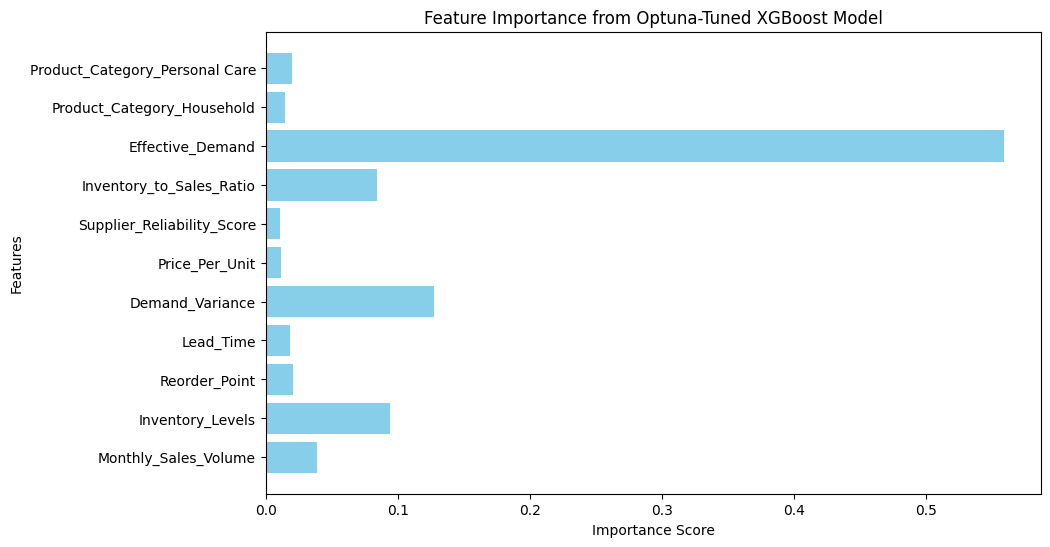

In [11]:
# ----------------------------------------------
# Step 7: Visualize Feature Importances
# ----------------------------------------------

# Extract feature importances from the Optuna-tuned model
# - feature_importances: A numerical measure of how much each feature contributes to the model's predictions.
# - X.columns: The names of the features corresponding to the importance scores.
feature_importances = best_xgb_model_optuna.feature_importances_
features = X.columns

# Plot feature importances
# - A horizontal bar chart is used for readability, showing the relative contribution of each feature.
plt.figure(figsize=(10, 6))  # Set the figure size for better visualization
plt.barh(features, feature_importances, color="skyblue")  # Create horizontal bars
plt.xlabel("Importance Score")  # Label for the x-axis
plt.ylabel("Features")  # Label for the y-axis
plt.title("Feature Importance from Optuna-Tuned XGBoost Model")  # Plot title
plt.show()  # Display the plot


In [12]:
# ----------------------------------------------
# Step 8: Save the Final Model
# ----------------------------------------------

# Save the Optuna-tuned model
joblib.dump(best_xgb_model_optuna, "optuna_tuned_xgboost_model.pkl")
print("Optuna-tuned model saved as 'optuna_tuned_xgboost_model.pkl'.")

Optuna-tuned model saved as 'optuna_tuned_xgboost_model.pkl'.
